<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_12/s12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download our code repository and install python dependencies

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git pull
!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"
!pip install --quiet "prettytable"
!pip install --quiet "torch_lr_finder"
!pip install --quiet "grad-cam"
!pip install --quiet "gradio"

Cloning into 'ERA_V1'...
remote: Enumerating objects: 1082, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 1082 (delta 106), reused 232 (delta 89), pack-reused 821
Receiving objects: 100% (1082/1082), 43.49 MiB | 17.79 MiB/s, done.
Resolving deltas: 100% (551/551), done.
fatal: not a git repository (or any of the parent directories): .git
fatal: destination path 'dl_hub' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

Add all the imports:

In [2]:
from __future__ import print_function
import os
import sys
from typing import Any
sys.path.append("dl_hub")
sys.path.append("ERA_V1/session_12")
import torch
import numpy as np
import gradio as gr
from PIL import Image
import pandas as pd
import seaborn as sn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from pytorch_lightning import seed_everything
from dl_hub.models.custom_resnet import CustomResnet, model_summary
from dl_hub.dataloaders.pl_custom_cifar10_datamodule import CustomCifar10DataModule
from dl_hub.models.pl_custom_resnet import LitResnet
from dl_hub.utils.helper_utils import find_best_lr, model_summary, get_incorrect_predictions, generate_grad_cam_visualizations
from dl_hub.utils.vis_utils import show_incorrect_predictions, plot_statistics, plot_losses, plot_accuracy, plot_lr_values, show_incorrect_predictions, plot_image_grid, preview_images, print_train_log
from dl_hub.PL_main import define_pl_model_resnet, build_data_module, train_and_eval_pl_model, get_max_lr


/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

Define all the Dataset related parameters

In [3]:
GLOBAL_SEED = 42
seed_everything(GLOBAL_SEED)
params = {}
train_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262), always_apply=True),
    A.transforms.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
    AA.crops.transforms.RandomCrop(height=32, width=32, always_apply=True),
    A.HorizontalFlip(),
    AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1,
                                            max_height=8,
                                            max_width=8,
                                            min_holes = 1,
                                            min_height=8,
                                            min_width=8,
                                            fill_value=(0.491, 0.482, 0.447),
                                            mask_fill_value = None),
    ToTensorV2()])
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262), always_apply=True),
    ToTensorV2(),])
val_transforms = test_transforms

params['train_transforms'] = train_transforms
params['val_transforms'] = val_transforms
params['test_transforms'] = test_transforms
params['val_split'] = 0.1
params['batch_size'] = 512 if torch.cuda.is_available() else 64
params['data_dir'] = os.environ.get("PATH_DATASETS", ".")
params['save_dir'] = "logs/"

# Define data module
cifar10_dm = build_data_module(params)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:lightning_fabric.utilities.seed:Global seed set to 42


100%|██████████| 170498071/170498071 [00:13<00:00, 12935080.10it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


Define all the Model related parameters

  0%|          | 0/200 [00:00<?, ?it/s]

/content/dl_hub/models/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.57E-02


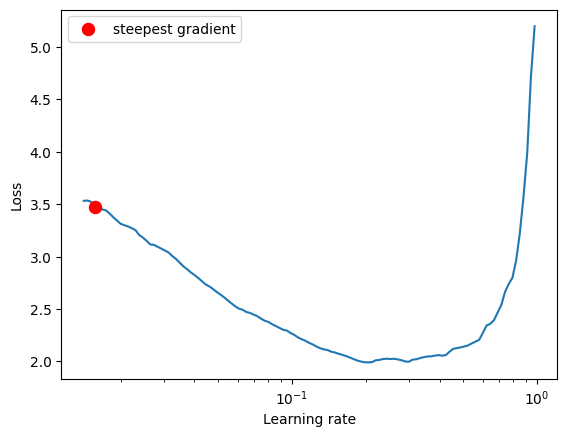

In [4]:
params['base_lr'] = 0.01
params['base_channels'] = 3
params['num_classes'] = 10
params['drop_out_probability'] = 0.1
params['loss_func'] = F.nll_loss
params['num_workers'] = 2
params['num_epochs'] = 24
params['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer_params = {
    'weight_decay': 1e-4,
    'lr': 0.01,
    'momentum': 0.9
}
params['optimizer_type'] = 'Adam'
params['optimizer_params'] = optimizer_params
max_lr = get_max_lr(params, cifar10_dm)

steps_per_epoch = len(cifar10_dm.train_dataset) // params['batch_size']
scheduler_params = {
    'max_lr': max_lr,
    'num_steps_per_epoch': steps_per_epoch,
    'epochs': params['num_epochs'],
    'pct_start': 5./params['num_epochs'],
    'div_factor': 2000,
    'three_phase': False,
    'final_div_factor':1,
    'anneal_strategy':'linear',
}
params['scheduler_type'] = 'OneCycleLR'
params['scheduler_params'] = scheduler_params

Define Resnet Model in Pytorch Lightning

In [5]:
# Define model
resnet_model = define_pl_model_resnet(params)
# Print Model Summary
model_summary(resnet_model, input_size = (3,32,32))

Layer (type:depth-idx)                        Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
LitResnet                                     --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─CustomResnet: 1-1                           --                        --                        --                        --                        --
│    └─Sequential: 2-1                        --                        [1, 3, 32, 32]            [1, 64, 32, 32]           --                        --
│    │    └─Conv2d: 3-1                       [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
│    │    └─BatchNorm2d: 3-2                  --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    │    └─ReLU: 3-3                         --                   

Train and test the model

In [6]:
# train and eval model
trainer = train_and_eval_pl_model(params, resnet_model, cifar10_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | CustomResnet | 6.6 M 
---------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.292    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/content/dl_hub/models/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=2088` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9312000274658203
        test_loss           0.2134944349527359
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Plot Model Metrics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,train_loss,train_acc,val_loss,val_acc
step,,,,
0,NaN,NaN,NaN,NaN
0,2.947037,0.093750,NaN,NaN
1,NaN,NaN,NaN,NaN
1,2.803341,0.091797,NaN,NaN
2,NaN,NaN,NaN,NaN


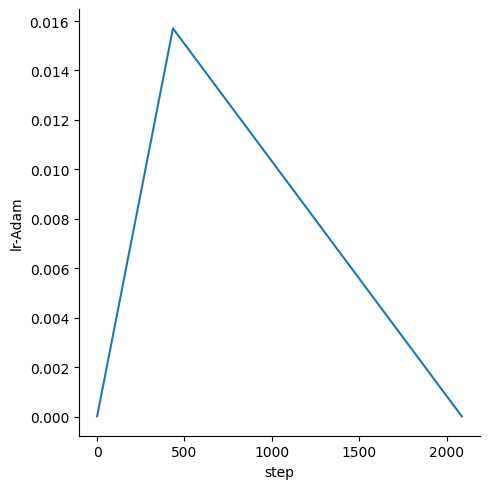

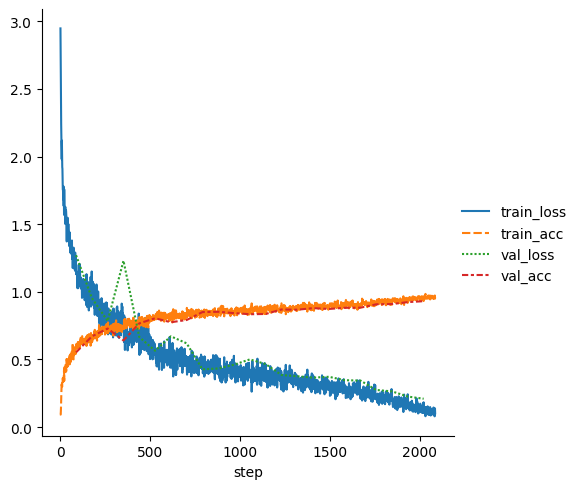

In [7]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["epoch"]
metrics.set_index("step", inplace=True)
sn.relplot(data=metrics['lr-Adam'], kind="line")
del metrics['lr-Adam'],metrics['test_acc'],metrics['test_loss']
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")


Show Incorrect Predictions

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/content/dl_hub/models/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


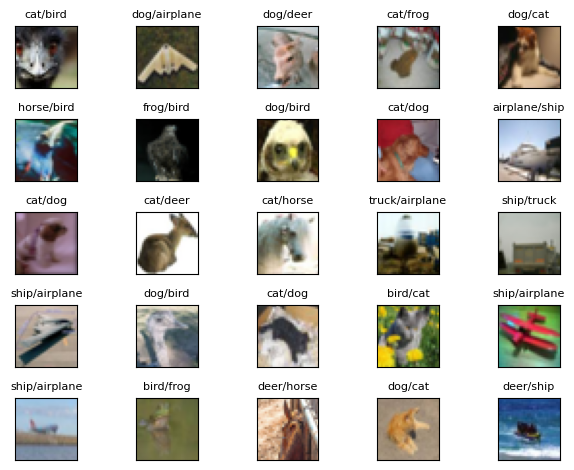

In [8]:
class_names = {"0": "airplane",
               "1": "automobile",
               "2": "bird",
               "3": "cat",
               "4": "deer",
               "5": "dog",
               "6": "frog",
               "7": "horse",
               "8": "ship",
               "9": "truck"}
num_rows = 5
num_cols = 5
test_loader = DataLoader(cifar10_dm.test_dataset, batch_size=params['batch_size'], num_workers=2, shuffle=False)
incorrect_predictions = get_incorrect_predictions(resnet_model.to(params['device']), test_loader, params['device'])
show_incorrect_predictions(incorrect_predictions, class_names, num_rows, num_cols)

Grad CAM Visualization of incorrect predictions

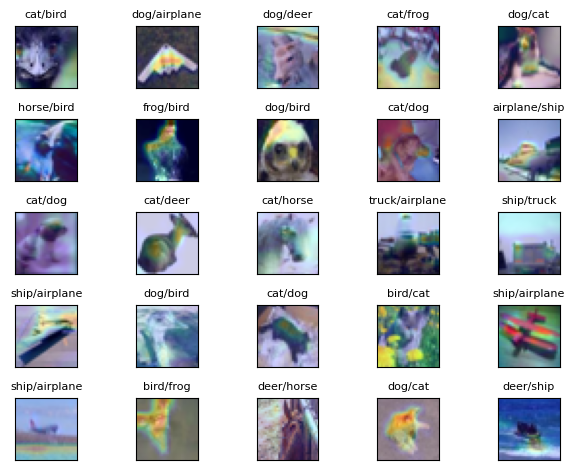

In [9]:
target_layers = [resnet_model.model.layer_2[-1]]
num_rows = 5
num_cols = 5
num_images_to_compute = num_rows*num_cols
grad_cam_map_list, prediction_list, ground_truth_list = generate_grad_cam_visualizations(resnet_model, target_layers, incorrect_predictions, class_names, num_images_to_compute=num_images_to_compute, image_weight=0.8)
plot_image_grid(grad_cam_map_list, prediction_list, ground_truth_list, num_rows, num_cols)

Save the Model

In [10]:
torch.save(resnet_model.state_dict(), "custom_resnet_model.pth")

## *Load the saved model so we can run inference and build gradio interface*

In [11]:
loss_func = params['loss_func']
base_lr = params['base_lr']
base_channels = params['base_channels']
num_classes = params['num_classes']
drop_out_probability = params['drop_out_probability']
num_epochs = params['num_epochs']
inference_model = LitResnet(loss_func, lr=base_lr,base_channels=base_channels, num_classes=num_classes,
                    drop_out_probability=drop_out_probability, epochs=num_epochs)

inference_model.load_state_dict(torch.load("ERA_V1/session_12/custom_resnet_model.pth", map_location=params['device']), strict=False)

<All keys matched successfully>

Add UI for Grad CAM Visualization

In [12]:
from pytorch_grad_cam import GradCAM
from torchvision import transforms
from dl_hub.utils.helper_utils import un_normalize_image
from pytorch_grad_cam.utils.image import show_cam_on_image
from collections.abc import Iterable


def get_target_block(model, layer_name):
    if layer_name == 'prep_layer':
        return [model.prep_layer[-1]]
    elif layer_name == 'layer_1':
        return [inference_model.model.layer_1.res_block.conv2[-1]]
    elif layer_name == 'layer_3':
        return [model.layer_3.res_block.conv2[-1]]
    elif layer_name == 'layer_2':
        return [model.layer_2[-1]]
    else:
        return None


def get_incorrect_predictions(model, test_loader, device, num_images):
    model.to(device)
    model.eval()
    incorrect_predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            if len(incorrect_predictions) > num_images:
                return incorrect_predictions
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            for d, t, p, o in zip(data, target,pred, output):
                if not p.eq(t.view_as(p)).item():
                    incorrect_predictions.append(
                        [d.cpu(), t.cpu(), p.cpu(),o[p.item()].cpu()]
                    )
    return incorrect_predictions


def get_misclassified_images(num_misclassified_images):
    incorrect_predictions = get_incorrect_predictions(inference_model, test_loader, params['device'], num_misclassified_images)
    mis_classified_images = []
    for this_pred in incorrect_predictions[:num_misclassified_images]:
        orig_img = this_pred[0]
        inv_transforms = transforms.Compose([transforms.Normalize((0.,0.,0.,),
                                            (1./0.247,1./0.244,1./0.262)),
                                        transforms.Normalize((-0.491,-0.482,-0.447),
                                                             (1.0,1.0,1.0))])
        un_normalized_tensor_img = inv_transforms(orig_img.squeeze())
        un_normalized_numpy_img = np.asarray(un_normalized_tensor_img)
        prediction = class_names[str(this_pred[2].item())]
        mis_classified_images.append((un_normalized_numpy_img.T, prediction))
    return mis_classified_images


def get_grad_cam_map(input_tensor, target_layers, image_weight):
    cam = GradCAM(model=inference_model, target_layers=target_layers, use_cuda=torch.cuda.is_available())
    grad_cam_output = cam(input_tensor=input_tensor, targets=None, aug_smooth=True, eigen_smooth=True)
    grad_cam_output = grad_cam_output[0,:]
    un_norm_image = un_normalize_image(input_tensor.cpu().squeeze())
    un_norm_image_np = np.asarray(un_norm_image).transpose((1,2,0))
    grad_cam_map = show_cam_on_image(un_norm_image_np, grad_cam_output, use_rgb=True, image_weight = image_weight)
    return grad_cam_map

def get_test_loader(cifar10_dm):
    cifar10_dm.setup(stage='test')
    test_loader = DataLoader(cifar10_dm.test_dataset, batch_size=params['batch_size'], num_workers=2, shuffle=False)
    return test_loader

def grad_cam_interface(show_misclassified_images, num_misclassified_images, input_image, num_classes_to_show, show_grad_cam, layer_name, image_weight):
    if input_image is None:
        raise gr.Error("Please Upload an image to compute prediction")
    # Show misclassified images
    if show_misclassified_images:
        print("computing misclassified images")
        misclassified_images = get_misclassified_images(int(num_misclassified_images))
    else:
        misclassified_images = []
    device = params['device']
    transform = transforms.ToTensor()
    if input_image is None:
        return None, None
    input_tensor = transform(input_image)
    input_tensor = input_tensor.unsqueeze(dim=0)
    input_tensor = input_tensor.to(device)
    inference_model.eval()
    with torch.no_grad():
        y = inference_model(input_tensor)
        softmax = torch.nn.Softmax(dim=0)
        o = softmax(y.flatten()).cpu()
        o_np = np.asarray(o.numpy())
        o_np = np.squeeze(o_np)
        output_class = class_names[str(o_np.argmax())]
    # Number of top classes
    if num_classes_to_show and int(num_classes_to_show) <= 10 and int(num_classes_to_show) >= 0:
        confidences = {class_names[str(i)]: float(o_np[i]) for i in range(int(num_classes_to_show))}
    else:
        confidences = {}# {class_names[str(i)]: float(o_np[i]) for i in range(10)}
        #gr.error("Invalid value for number of classes. Showing confidence levels of all classes")
        raise gr.Error("Invalid value for 'Number of to classes to show'. Should be between 0 and 10")

    # Show Grad Cam
    if show_grad_cam:
        # Get the target layer
        target_layers = get_target_block(inference_model.model, layer_name)
        if target_layers is None:
            raise gr.Error("Please select the layer on which to compute GradCAM")
        grad_cam_map = get_grad_cam_map(input_tensor, target_layers, image_weight)
    else:
        grad_cam_map = None

    return output_class, confidences, misclassified_images, grad_cam_map
    #return confidences, grad_cam_map, output_class


#ask the user whether he/she wants to see GradCAM images and how many, and from which layer, allow opacity change as well
#ask whether he/she wants to view misclassified images, and how many
#allow users to upload new images, as well as provide 10 example images
#ask how many top classes are to be shown (make sure the user cannot enter more than 10)

class_names = {"0": "Aeroplane",
               "1": "Automobile",
               "2": "Bird",
               "3": "Cat",
               "4": "Deer",
               "5": "Dog",
               "6": "Frog",
               "7": "Horse",
               "8": "Ship",
               "9": "Truck"}
layer_names = ['prep_layer', 'layer_1', 'layer_2', 'layer_3']
test_loader = get_test_loader(cifar10_dm)

cifar_examples = [['Aeroplane.jpeg'],
            ['Automobile.jpeg'],
            ['Bird.jpeg'],
            ['Cat.jpeg'],
            ['Deer.jpeg'],
            ['Dog.jpeg'],
            ['Frog.jpeg'],
            ['Horse.jpeg'],
            ['Ship.jpeg'],
            ['Truck.jpeg']]
v1 = gr.Interface(grad_cam_interface,
                  inputs = [gr.Checkbox(False, label="Show Misclassified Images"),
                            gr.Textbox('25', label="Number of misclassified Images"),
                            gr.Image(shape=(32, 32)),
                            gr.Textbox('10', label="Number of top classes to show"),
                            gr.Checkbox(True, label="See GradCAM Map"),
                            gr.Dropdown(layer_names,value='layer_2',label="Layer to visualize"),
                            gr.Slider(0, 1,0.8,label="Image Opacity")],
                  outputs = [gr.Textbox(label='Prediction'),
                             gr.Label(),
                             gr.Gallery(label='Misclassified Images', show_label=True),
                             gr.Image(shape=(32, 32),label='Grad CAM').style(width=128, height=128),
                             ],
                  examples=cifar_examples)
v1.queue()
v1.launch(share=True, debug=False)

<ipython-input-12-114c691e195a>:155: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  gr.Image(shape=(32, 32),label='Grad CAM').style(width=128, height=128),


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()


/usr/local/lib/python3.10/dist-packages/gradio/analytics.py:46: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(latest_pkg_version) > StrictVersion(current_pkg_version):


Running on public URL: https://5f240eb34c94b063d6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
